In [128]:
import numpy as np
import matplotlib.pylab as plt
from scipy.fft import fftn, ifftn
from scipy.fft import fftshift, fftfreq
from scipy.signal.windows import blackman
#from skimage.feature import register_translation as skimage_phase_cross_correlation
from skimage.registration import phase_cross_correlation as skimage_phase_cross_correlation

import skimage
from scipy.interpolate import interp2d
#from scipy.ndimage import gaussian_filter

from scipy.optimize import minimize



# Registration using optimisation

Balci, Murat, et Hassan Foroosh. « Subpixel Registration Directly from the Phase Difference ». EURASIP Journal on Advances in Signal Processing 2006, nᵒ 1 (décembre 2006). https://doi.org/10.1155/ASP/2006/60796.


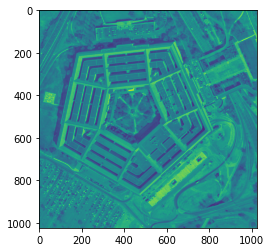

In [29]:
# ================
#  Generate data
# ================

# Pentagon aerial photo
# http://sipi.usc.edu/database/database.php?volume=aerials&image=37#top
image = skimage.data.camera()
image = skimage.io.imread('pentagon_1024.tiff')
image = skimage.exposure.rescale_intensity(image)
#image = gaussian_filter(image, sigma=5)
plt.imshow(image);

In [30]:
# Interpolation
#x_span, y_span = np.arange(image.shape[0]), np.arange(image.shape[1])
#x_grid, y_grid = np.meshgrid(x_span, y_span)

#f = interp2d(x_span, y_span, image, kind='cubic')

#x_A = np.arange(20, 281)
#y_A = np.arange(80, 232)a 

#dx, dy = (0.7512, 50.101512)
#A = f(x_A, y_A)
#B = f(x_A + dx, y_A + dy)  #+ 0.81*np.random.randn(*np.shape(A))

#plt.imshow(A - B);

In [31]:
# FFT shift interpolation
def fft_translate(A, dy, dx):
    a = fftn(A)
    kx = fftfreq(A.shape[0])
    ky = fftfreq(A.shape[1])
    k_xy = np.meshgrid(kx, ky, indexing='ij')

    b = a*np.exp(-1j*2*np.pi*(dx*k_xy[0] + dy*k_xy[1]))

    B = np.abs( ifftn(b) ) 
    return B

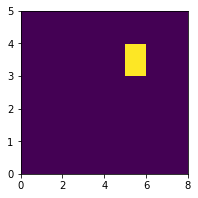

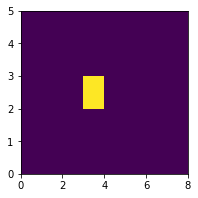

In [32]:
# test
A = np.zeros((5, 8))
A[3, 5] = 1

B = fft_translate(A, -2, -1)

plt.figure(figsize=(3, 3));
plt.pcolormesh(A)
plt.figure(figsize=(3, 3));
plt.pcolormesh(B)

In [33]:
from skimage.transform import rotate

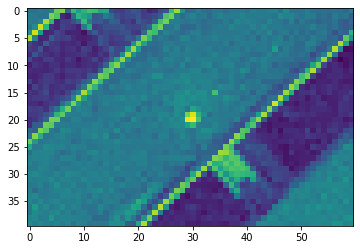

In [34]:
# Translate & Crop

dx, dy = 4.32, 0.35#5.4, 6.6

x, y = 580, 668
Lx, Ly = 60, 40
A = image[y:y+Ly, x:x+Lx]
B = rotate(image, 13, center=(x+Lx/2, y+Ly/2))
B = fft_translate(B, dx, dy)[y:y+Ly, x:x+Lx]
B += 0.005*np.random.randn(*B.shape)
plt.imshow(A);

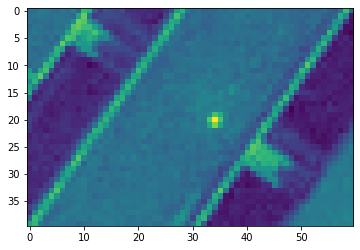

In [35]:
plt.imshow(B);

In [36]:
def phase_cross_correlation(A, B, upsamplefactor=1, phase=True):

    if phase:
        u = blackman(A.shape[0])
        v = blackman(A.shape[1])
        window = u[:, np.newaxis] * v[np.newaxis, :]
    else:
        window = 1
        
    a, b = fftn(A * window), fftn(B * window)
    
    ab = a * b.conj()
    if phase:
        ab = ab / np.abs(ab)
    phase_corr = ifftn(fftshift(ab),
                       s=upsamplefactor*np.array(ab.shape))
    phase_corr = np.abs( fftshift(phase_corr) )

    dx_span = fftshift( fftfreq(phase_corr.shape[1]) )*A.shape[1]
    dy_span = fftshift( fftfreq(phase_corr.shape[0]) )*A.shape[0]

    return dx_span, dy_span, phase_corr

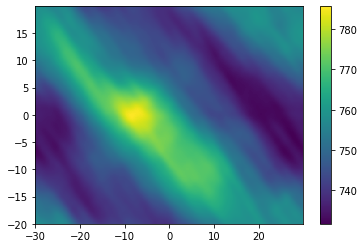

In [37]:
plt.pcolormesh(*phase_cross_correlation(A, B, upsamplefactor=10, phase=False))
plt.colorbar()

[-0.1 -8.4]


/home/etienne/jupyter/py3/lib/python3.8/site-packages/skimage/feature/__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')


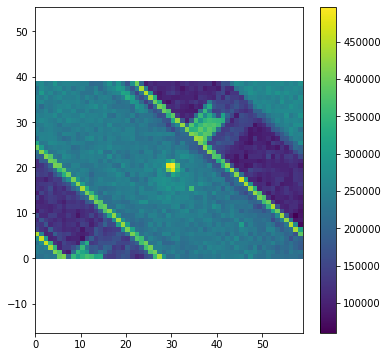

In [109]:
def dft_tensordot(data, yx):
    im2pi = 1j * 2 * np.pi
    y, x = yx
    yky = np.exp( im2pi * y * fftfreq(data.shape[0]) )
    xkx = np.exp( im2pi * x * fftfreq(data.shape[1]) )
    
    data = np.tensordot(xkx, data, axes=(0, -1))
    data = np.tensordot(yky, data, axes=(0, -1))    
    return data


def grad_dft(data, yx):
    im2pi = 1j * 2 * np.pi
    y, x = yx
    kx = im2pi * fftfreq(data.shape[1])
    ky = im2pi * fftfreq(data.shape[0])
    
    exp_kx = np.exp(x * kx)
    exp_ky = np.exp(y * ky)
    
    gradx = np.tensordot(exp_kx * kx, data, axes=(0, -1))
    gradx = np.tensordot(exp_ky, gradx, axes=(0, -1))
    
    grady = np.tensordot(exp_kx, data, axes=(0, -1))
    grady = np.tensordot(exp_ky * ky, grady, axes=(0, -1))  
    
    return np.array([grady, gradx])

# Verif. custom_dft
zoom_factor = 1
#y_span = np.linspace(-A.shape[0]/zoom_factor - dy, +A.shape[0]/zoom_factor - dy, 45)
#x_span = np.linspace(-A.shape[1]/zoom_factor - dx, +A.shape[1]/zoom_factor - dx, 54)

y_span = np.arange(A.shape[0])
x_span = np.arange(A.shape[1])

x_grid, y_grid = np.meshgrid(x_span, y_span)
x_flat, y_flat = x_grid.flatten(), y_grid.flatten()
xy = np.vstack([y_flat, x_flat]).T

a = fftn(A)
dft = np.array( [np.real( dft_tensordot(a, xy_i) ) for xy_i in xy] )
dft = dft.reshape(x_grid.shape)

plt.figure(figsize=(6, 6))
plt.pcolormesh(x_span, y_span, dft); plt.axis('equal');
plt.colorbar();

In [137]:
def phase_cross_correlation_optim(A, B):
    phase = True
    upsamplefactor = 1

    if phase:
            u = blackman(A.shape[0])
            v = blackman(A.shape[1])
            window = u[:, np.newaxis] * v[np.newaxis, :]
    else:
        window = 1

    a, b = fftn(A * window), fftn(B * window)

    ab = a * b.conj()
    if phase:
        ab = ab / np.abs(ab)

    phase_corr = ifftn(fftshift(ab),
                       s=upsamplefactor*np.array(ab.shape))
    phase_corr = np.abs( fftshift(phase_corr) )

    dx_span = fftshift( fftfreq(phase_corr.shape[1]) )*A.shape[1]
    dy_span = fftshift( fftfreq(phase_corr.shape[0]) )*A.shape[0]

    # argmax
    argmax_idx = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
    argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
    #print(f"{argmax}")

    def cost(xy, ab):
        return -np.abs(dft_tensordot(ab, xy))

    def jac(xy, ab):
        return -np.real(grad_dft(ab, xy))

    res = minimize(cost, argmax, args=(ab, ), method='BFGS', tol=1e-3)#, jac=jac)
    return res.x, res.hess_inv, res

[ 0.  -8.4]


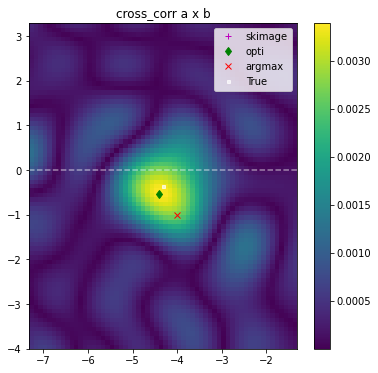

In [138]:
# cross_corr
plt.figure(figsize=(6, 6))
#plt.pcolormesh(dx_span, dy_span, cross_corr, shading='flat');
plt.pcolormesh(*phase_cross_correlation(A, B, upsamplefactor=10, phase=True),
               shading='flat');
plt.axis('equal')
plt.title('cross_corr a x b'); plt.colorbar();

# Verif  phase_cross_correlation
shifts, _, _ = skimage_phase_cross_correlation(A, B, upsample_factor=5)
print(shifts)

plt.plot(*shifts[::-1], '+m', label='skimage');
plt.plot(*res.x[::-1], 'dg', label='opti');
plt.plot(*argmax[::-1], 'xr', label='argmax');
plt.plot(-dx, -dy, 'sw', markersize=3, label='True', alpha=0.7);

plt.legend();plt.axvline(x=0, linestyle='--', color='white', alpha=0.5);
plt.axhline(y=0, linestyle='--', color='white', alpha=0.5);

zoom_factor = 20
plt.ylim([-A.shape[0]/zoom_factor - dy, +A.shape[0]/zoom_factor - dy ]);
plt.xlim([-A.shape[1]/zoom_factor - dx, +A.shape[1]/zoom_factor - dx]);


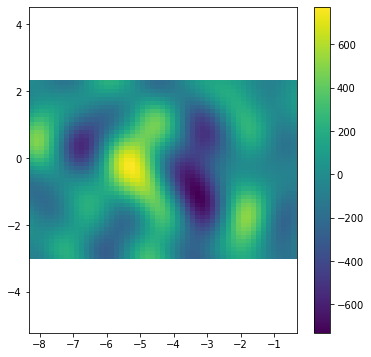

In [119]:
# Verif. custom_dft
zoom_factor = 15
y_span = np.linspace(-A.shape[0]/zoom_factor - dy, +A.shape[0]/zoom_factor - dy, 45)
x_span = np.linspace(-A.shape[1]/zoom_factor - dx, +A.shape[1]/zoom_factor - dx, 54)

x_grid, y_grid = np.meshgrid(x_span, y_span)
x_flat, y_flat = x_grid.flatten(), y_grid.flatten()
xy = np.vstack([y_flat, x_flat]).T

a = fftn(A)
dft = np.array( [np.real( grad_dft(ab, xy_i)[1] ) for xy_i in xy] )
dft = dft.reshape(x_grid.shape)

plt.figure(figsize=(6, 6))
plt.pcolormesh(x_span, y_span, dft); plt.axis('equal');
plt.colorbar();

In [125]:
%%timeit
res = minimize(cost, argmax, args=(ab, ), method='BFGS', tol=1e-2)#, jac=jac)
# 3.02 ms ± 38.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)  jac
# 3.88 ms ± 34.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each) 

3.11 ms ± 44.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [136]:
%%timeit
shifts, _, _ = skimage_phase_cross_correlation(A, B, upsample_factor=100)

3.62 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [132]:
skimage_phase_cross_correlation(A, B, upsample_factor=10)

(array([-0.1, -8.4]), 0.33376228301797456, -3.565641675155324e-06)

In [139]:
phase_cross_correlation_optim(A, B)

(array([-0.53808682, -4.39689598]),
 array([[ 0.00075392, -0.00020349],
        [-0.00020349,  0.0008294 ]]),
       fun: -816.2221462054918
  hess_inv: array([[ 0.00075392, -0.00020349],
        [-0.00020349,  0.0008294 ]])
       jac: array([-1.52587891e-05, -1.52587891e-05])
   message: 'Optimization terminated successfully.'
      nfev: 40
       nit: 6
      njev: 10
    status: 0
   success: True
         x: array([-0.53808682, -4.39689598]))

- actually similar to search max of the inverse transform (DFT)
- Faster than 2nd DFT ? (grid search)
    - according to Manuel Guizar-Sicairos no  
    but why ?  (python ?)
        
- error estimatin -> cov matrix... given by the optim

- cross-correlation (used)  vs phase-correlation
- windowing or not ?

windowing + phase seems to be best...

    Kybic, J. « Bootstrap Resampling for Image Registration Uncertainty Estimation Without Ground Truth ». IEEE Transactions on Image Processing 19, nᵒ 1 (janvier 2010): 64‑73. https://doi.org/10.1109/TIP.2009.2030955.


- fit (cos(phi), sin(phi)) instead of 
the peak summit quadratic, or phi%pi

- but non linear... so do the interpolation&fit directly--> high order transformation

- windowing and phase corr.
- direct
- initial upsampling (use argmax to initial guess)
- derivative ?
